# Propensity Score Matching in Sales and Marketing
Propensity Score Matching (PSM) is a statistical technique used to estimate the causal effect of a treatment or intervention, particularly in scenarios where randomization isn’t feasible.

In sales and marketing, it helps evaluate the impact of campaigns by addressing selection bias—when customers self-select into treatment groups (e.g., opting into a discount program or seeing targeted ads).

PSM involves:
Calculating Propensity Scores: Logistic regression estimates the probability of a customer receiving the treatment based on observed factors like age, income, or past spending.
Matching: Customers in the treatment group are paired with similar customers in the control group based on their propensity scores.
Outcome Comparison: The matched groups are compared to determine the treatment's effect, such as increased sales or improved engagement.
Example in Marketing: A retailer launches a loyalty program to boost purchases. Using PSM, they compare purchase behavior between loyalty members (treated) and matched non-members (control). This approach isolates the program’s true impact, controlling for confounding factors like spending habits.
PSM enables marketers to make data-driven decisions by offering a clearer view of what drives customer behavior, ensuring campaigns are both effective and efficient.


## Scenario:
A company launched a digital marketing campaign targeting specific customers to increase their purchase rate. We want to evaluate the effectiveness of the campaign (treatment) on sales. Customers self-selected into the campaign, leading to potential confounders like age, income, and past spending.

## Steps:
1. Logistic Regression: Estimate the propensity scores.
Dependent variable: Treated (1/0)
Independent variables: Age, Income, Past_Spend
2. Propensity Score Matching: Match treated and untreated customers based on their propensity scores to balance the groups.
3. Outcome Analysis: Compare the purchase rate between matched treated and control groups to evaluate the campaign's effect.

In [76]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
#getting a look at the data
df = pd.read_excel("C:/Users/HP/Downloads/PSM CAMPAIGN DATA.xlsx")
df.head()

,CustomerID,Age,Income,Past_Spend,Treated,Purchase
0,C1,25,35000,200,1,1
1,C2,40,60000,1500,0,0
2,C3,30,45000,800,1,1
3,C4,35,50000,1000,0,1
4,C5,28,40000,500,1,1


In [80]:
# checking for missing data
df.isna().sum()

CustomerID    0
Age           0
Income        0
Past_Spend    0
Treated       0
Purchase      0
dtype: int64

In [82]:
# Features and target for propensity score calculation
X = df[["Age", "Income", "Past_Spend"]]
y = df["Treated"]

In [84]:
# Standardize features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [86]:
# Logistic regression for propensity scores
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)
df["Propensity_Score"] = log_reg.predict_proba(X_scaled)[:, 1]

print("Propensity Scores:\n", df[["CustomerID", "Propensity_Score"]])

Propensity Scores:
    CustomerID  Propensity_Score
0          C1          0.613929
1          C2          0.588318
2          C3          0.614252
3          C4          0.592464
4          C5          0.610614
5          C6          0.593503
6          C7          0.625940
7          C8          0.602048
8          C9          0.590546
9         C10          0.462734
10        C11          0.564041
11        C12          0.942280
12        C13          0.521320
13        C14          0.633809
14        C15          0.582991
15        C16          0.606783
16        C17          0.673284
17        C18          0.641151
18        C19          0.628729
19        C20          0.596049
20        C21          0.561737
21        C22          0.442155
22        C23          0.539581
23        C24          0.981705
24        C25          0.746340
25        C26          0.647266
26        C27          0.497172
27        C28          0.559003
28        C29          0.445407
29        C30       

In [88]:
# Match treated and untreated based on Propensity Scores
treated = df[df["Treated"] == 1]
untreated = df[df["Treated"] == 0]

# Calculate distances between propensity scores
distances = pairwise_distances(
    treated[["Propensity_Score"]], untreated[["Propensity_Score"]], metric="euclidean"
)

In [90]:
# Ensure treated is a copy of the filtered DataFrame to avoid the SettingWithCopyWarning
treated = df[df["Treated"] == 1].copy()

# Add the "Match" column using the index of the nearest untreated customer
treated["Match"] = distances.argmin(axis=1)

# Use the indices of the nearest untreated customers to extract rows from the untreated DataFrame
matched_untreated = untreated.iloc[distances.argmin(axis=1)].reset_index(drop=True)

In [92]:
# Create the matched dataset
matched_data = pd.concat([treated, matched_untreated])
print("\nMatched Data:\n", matched_data)


Matched Data:
    CustomerID  Age  Income  Past_Spend  Treated  Purchase  Propensity_Score  \
0          C1   25   35000         200        1         1          0.613929   
2          C3   30   45000         800        1         1          0.614252   
4          C5   28   40000         500        1         1          0.610614   
6          C7   22   30000         100        1         0          0.625940   
9         C10   56   89000         720        1         1          0.462734   
10        C11   44   95000         900        1         0          0.564041   
11        C12   39   35000       15000        1         1          0.942280   
13        C14   25   53000         300        1         1          0.633809   
15        C16   55  150000        2500        1         0          0.606783   
16        C17   29   87000        1200        1         1          0.673284   
17        C18   33   70000        1400        1         1          0.641151   
19        C20   29   45000         2

In [94]:
# Outcome Analysis: Compare Purchase Rate
treated_purchase_rate = matched_data[matched_data["Treated"] == 1]["Purchase"].mean()
untreated_purchase_rate = matched_data[matched_data["Treated"] == 0]["Purchase"].mean()

print(f"\nTreated Purchase Rate: {treated_purchase_rate}")
print(f"Untreated Purchase Rate: {untreated_purchase_rate}")
print(f"Campaign Effect: {treated_purchase_rate - untreated_purchase_rate}")


Treated Purchase Rate: 0.5517241379310345
Untreated Purchase Rate: 0.896551724137931
Campaign Effect: -0.3448275862068966


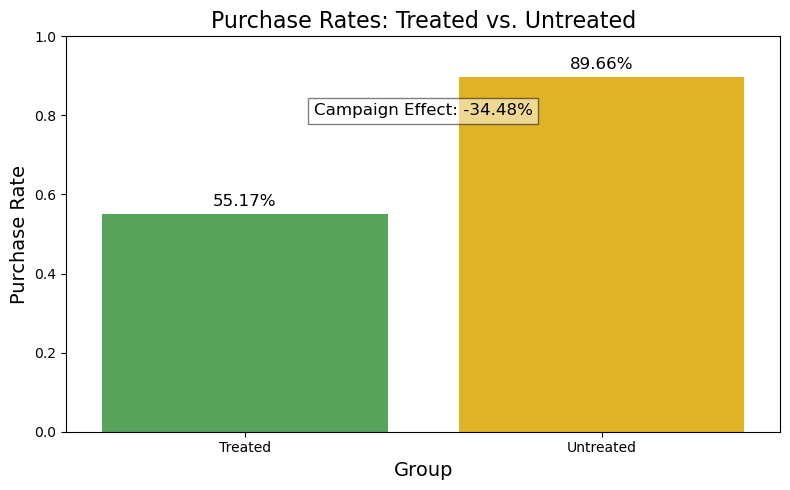

In [98]:
# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=purchase_rates, hue=categories, dodge=False, 
            palette={"Treated": "#4CAF50", "Untreated": "#FFC107"}, legend=False)

# Add titles and labels
plt.title("Purchase Rates: Treated vs. Untreated", fontsize=16)
plt.ylabel("Purchase Rate", fontsize=14)
plt.xlabel("Group", fontsize=14)
plt.ylim(0, 1)  # Assuming purchase rates are proportions (0 to 1)
for i, rate in enumerate(purchase_rates):
    plt.text(i, rate + 0.02, f"{rate:.2%}", ha="center", fontsize=12)

# Display the Campaign Effect as text
plt.text(0.5, 0.8, f"Campaign Effect: {campaign_effect:.2%}", 
         fontsize=12, ha="center", bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.tight_layout()
plt.show()

## Explanation of the Results
Treated Purchase Rate: 0.5517 (55.17%)

This is the proportion of treated customers who made a purchase.
Treated customers are those who were part of the campaign (e.g., exposed to a marketing effort like an email or ad).
A purchase rate of ~55% indicates that slightly more than half of the treated customers converted (made a purchase).
Untreated Purchase Rate: 0.8966 (89.66%)

This is the proportion of untreated customers who made a purchase.
Untreated customers are those who were not part of the campaign (e.g., not exposed to the marketing effort).
A purchase rate of ~90% suggests that most untreated customers converted, even without exposure to the campaign.
Campaign Effect: -0.3448 (-34.48%)


## Insights
The untreated group’s high purchase rate (~90%) suggests they might already be highly motivated buyers.
This could mean the campaign was unnecessary for these customers.


## Recommendations for Action
Reassess Campaign Targeting

Was the campaign targeting customers who were already likely to purchase?
Consider narrowing the audience to those less likely to purchase without intervention.
Evaluate Campaign Content

Was the message or creative aligned with customer preferences?
Test alternative messages or offers to see if they perform better.
Analyze Customer Segments

Run an A/B test to validate the findings.
Ensure random assignment of treated and untreated groups to reduce biases.